In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

## 数据下载

In [2]:
import torchvision
import torch.utils.data.dataloader as Data

train_data = torchvision.datasets.FashionMNIST(
    '../data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST(
    '../data', train=False, transform=torchvision.transforms.ToTensor())
print("train_data:", train_data.train_data.size())
print("train_labels:", train_data.train_labels.size())
print("test_data:", test_data.test_data.size())

train_data: torch.Size([60000, 28, 28])
train_labels: torch.Size([60000])
test_data: torch.Size([10000, 28, 28])


C:\Users\15710\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\15710\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\15710\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [3]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=64)

In [4]:
# sample
for x, y in train_loader:
    print(x.shape) # Batch_size, Channel, Height, Width
    print(y.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


## 模型

In [5]:
# LeNet-5
device = "cuda" if torch.cuda.is_available() else "cpu"

num_class = 10
class LeNet(nn.Module):
    def __init__(self, n_class):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) #insize:28  outsize: 28-5+1 = 24
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_class)

    def forward(self, x):
#         print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))  # outsize: 24/2 = 12
#         print(x.shape)
        x = self.pool(F.relu(self.conv2(x))) # (12-5+1=8)/2 = 4
#         print(x.shape)
        x = x.view(-1, 16 * 4 * 4) # channel * 4 * 4
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = LeNet(num_class)
net.to(device)
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 测试函数

In [6]:
 # evaluation--------------------------------
def evaluation(net, test_data, test_loader):
    net.eval()
    eval_loss = 0.
    eval_acc = 0.
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = net(X)
            l = loss(pred, y)
            eval_loss += l.cpu().item()
            pred = torch.max(pred, 1)[1] # torch.max() [0]返回最大值 [1]最大值的索引
            num_correct = (pred == y).sum() # 预测正确数
            eval_acc += num_correct
        print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(
                test_data)), eval_acc / (len(test_data))))
    return eval_loss/len(test_data), eval_acc/len(test_data)

 # 推理一张图片类别
classes = ['T恤', '裤子', '套头衫', '连衣裙', '外套', '凉鞋', 衬衫', '运动鞋', '包', '靴子']
def infer(net, img, device):
    net.eval()
    with torch.no_grad():
    X = X.to(device)
    pred = net(X)
    pred = torch.max(pred, 1)[1]
    show(img)
    print("鉴定为:"+ classes[pred])

## 训练函数

In [12]:
net = LeNet(num_class)
net.to(device)
# 超参数
lr = 2e-1
num_epochs = 5
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
# 指数衰减  ---以指数衰减,gamma代表指数函数的底数---
# ExpLR = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
# 固定衰减  ---按固定步长step_size衰减学习率---
# StepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.01)
# 多步长衰减  ---在milestones的区间[1, 3]的区间右侧衰减学习率---
# MultiStepLR = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1, 3], gamma=0.01)
# 余弦退火 ---学习率按周期性变化---
CosineLR = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2, eta_min=0) # T_max:余弦函数周期, eta_min:学习率最小值(0表示至少为正)

loss = nn.CrossEntropyLoss()
history = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}


print("training on", device)
for epoch in range(num_epochs):
    print('epoch {}'.format(epoch + 1))
    # training-----------------------------
    net.train()
    train_loss = 0.
    train_acc = 0.
    
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        pred = net(X)
        l = loss(pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        with torch.no_grad():
            train_loss += l.cpu().item()
            pred = torch.max(pred, 1)[1] # torch.max() [0]返回最大值 [1]最大值的索引
            num_correct = (pred == y).sum() # 预测正确数
            train_acc += num_correct
            
    train_loss, train_acc = train_loss/len(train_data), train_acc/len(train_data)
    test_loss, test_acc = evaluation(net, test_data, test_loader)
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss, train_acc))
   
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)

training on cpu
epoch 1
Test Loss: 0.007629, Acc: 0.827800
Train Loss: 0.011662, Acc: 0.718650
epoch 2
Test Loss: 0.006239, Acc: 0.850000
Train Loss: 0.006333, Acc: 0.850017
epoch 3
Test Loss: 0.005782, Acc: 0.862700
Train Loss: 0.005441, Acc: 0.869717
epoch 4
Test Loss: 0.006048, Acc: 0.858300
Train Loss: 0.004976, Acc: 0.881917
epoch 5
Test Loss: 0.005352, Acc: 0.871600
Train Loss: 0.004688, Acc: 0.887367


## 模型保存与加载

In [8]:
torch.save(net.state_dict(), "../model/LeNet_Minst.pt")

In [9]:
net = LeNet(num_class)
net.load_state_dict(torch.load('../model/LetNet_Minst.pt', map_location=device))
net.to(device)

<All keys matched successfully>

## 绘图loss与Acc

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(history):
    fig, ax = plt.subplots()
    fig.autofmt_xdate() 
    plt.xlabel("epochs")
    plt.ylabel("loss")
    idx = [i+1 for i in range(len(history["train_loss"]))]
    
    l1, = plt.plot(idx,history["train_loss"], color="red")
    l2, = plt.plot(idx,history["test_loss"],color="green")
    plt.legend([l1, l2],
           ['train_loss', 'test_loss'],
           loc='upper right'
    )
    plt.show()

def plot_acc(history):
    fig, ax = plt.subplots()
    plt.xlabel("epochs")
    plt.ylabel("acc")
    idx = [i+1 for i in range(len(history["train_acc"]))]
    l1, = plt.plot(idx,history["train_acc"], color="red")
    l2, = plt.plot(idx,history["test_acc"],color="green")
    plt.legend([l1, l2],
           ['train_acc', 'test_acc'],
           loc='upper right'
    )
    plt.show()

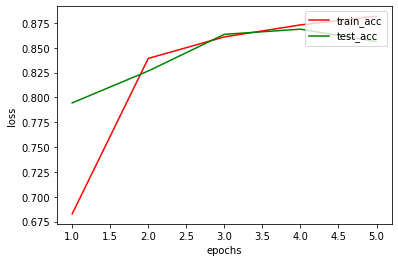

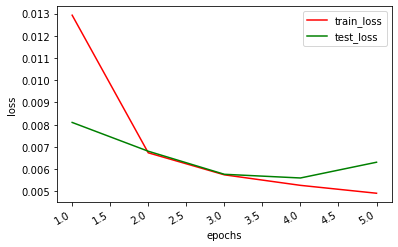

In [11]:
plot_acc(history=history)
plot_loss(history=history)